In [9]:
%matplotlib inline

# BaristaSeq

BaristaSeq is an assay that sequences padlock-probe initiated rolling circle
amplified spots using a one-hot codebook. The publication for this assay can be
found [here](https://www.ncbi.nlm.nih.gov/pubmed/29190363)

This example processes a single field of view extracted from a tissue slide that
measures gene expression in mouse primary visual cortex.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import starfish
import starfish.data
from starfish.types import Axes
from starfish import FieldOfView
from starfish.util.plot import (
    imshow_plane, intensity_histogram, overlay_spot_calls
)

matplotlib.rcParams["figure.dpi"] = 150

Load Data
---------
Import starfish and extract a single field of view.

In [12]:
exp = starfish.data.BaristaSeq(use_test_data=False)

nissl = exp.fov().get_image('nuclei')
img = exp.fov().get_image(FieldOfView.PRIMARY_IMAGES)

starfish data are 5-dimensional, but to demonstrate what they look like in a
non-interactive fashion, it's best to visualize the data in 2-d. There are
better ways to look at these data using the `starfish.display`
method, which allows the user to page through each axis of the tensor

100%|██████████| 17/17 [00:00<00:00, 150.42it/s]


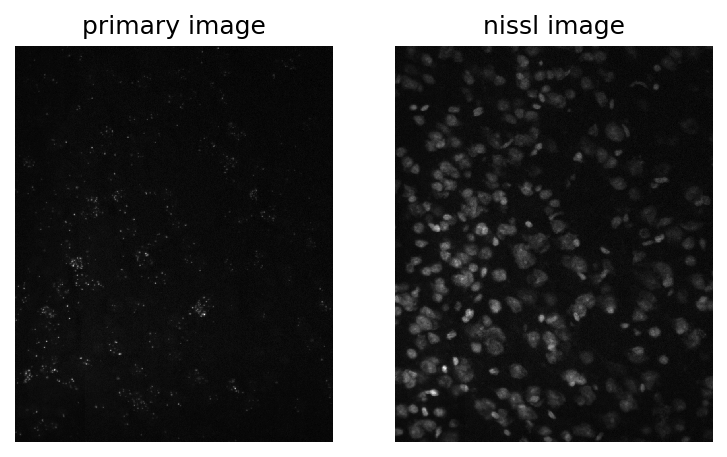

In [13]:
# for this vignette, we'll pick one plane and track it through the processing
# steps
plane_selector = {Axes.CH: 0, Axes.ROUND: 0, Axes.ZPLANE: 8}

f, (ax1, ax2) = plt.subplots(ncols=2)
imshow_plane(img, sel=plane_selector, ax=ax1, title="primary image")
imshow_plane(nissl, sel=plane_selector, ax=ax2, title="nissl image")

Register the data
-----------------
The first step in BaristaSeq is to do some rough registration. For this data,
the rough registration has been done for us by the authors, so it is omitted
from this notebook.

Project into 2D
---------------
BaristaSeq is typically processed in 2d. Starfish allows users to reduce data using arbitrary
methods via `starfish.image.Filter.Reduce`.  Here we max project Z for both the nissl images and
the primary images.

100%|██████████| 1/1 [00:00<00:00, 195.05it/s]


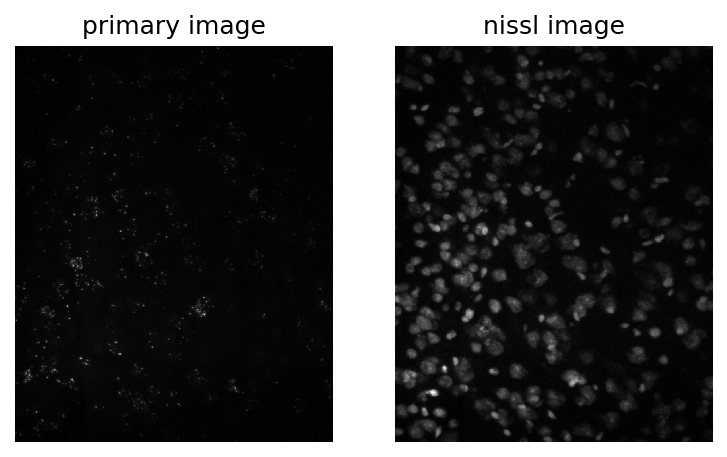

In [14]:
from starfish.image import Filter
from starfish.types import FunctionSource
max_projector = Filter.Reduce((Axes.ZPLANE,), func=FunctionSource.np("max"))
z_projected_image = max_projector.run(img)
z_projected_nissl = max_projector.run(nissl)

# show the projected data
f, (ax1, ax2) = plt.subplots(ncols=2)
imshow_plane(z_projected_image, sel={Axes.CH: 0, Axes.ROUND: 0}, ax=ax1, title="primary image")
imshow_plane(z_projected_nissl, sel={Axes.CH: 0, Axes.ROUND: 0}, title="nissl image")

Correct Channel Misalignment
----------------------------
There is a slight miss-alignment of the C channel in the microscope used to
acquire the data. This has been corrected for this data, but here is how it
could be transformed using python code for future datasets.

In [15]:
# from skimage.feature import register_translation
# from skimage.transform import warp
# from skimage.transform import SimilarityTransform
# from functools import partial

# # Define the translation
# transform = SimilarityTransform(translation=(1.9, -0.4))

# # C is channel 0
# channels = (0,)

# # The channel should be transformed in all rounds
# rounds = np.arange(img.num_rounds)

# # apply the transformation in place
# slice_indices = product(channels, rounds)
# for ch, round_, in slice_indices:
#     selector = {Axes.ROUND: round_, Axes.CH: ch, Axes.ZPLANE: 0}
#     tile = z_projected_image.get_slice(selector)[0]
#     transformed = warp(tile, transform)
#     z_projected_image.set_slice(
#         selector=selector,
#         data=transformed.astype(np.float32),
#     )

Remove Registration Artefacts
-----------------------------
There are some minor registration errors along the pixels for which y < 100
and x < 50. Those pixels are dropped from this analysis

In [16]:
registration_corrected: starfish.ImageStack = z_projected_image.sel(
    {Axes.Y: (100, -1), Axes.X: (50, -1)}
)

Correct for bleed-through from Illumina SBS reagents
----------------------------------------------------
The following matrix contains bleed correction factors for Illumina
sequencing-by-synthesis reagents. Starfish provides a LinearUnmixing method
that will unmix the fluorescence intensities

In [17]:
data = np.array(
    [[ 1.  , -0.05,  0.  ,  0.  ],
     [-0.35,  1.  ,  0.  ,  0.  ],
     [ 0.  , -0.02,  1.  , -0.84],
     [ 0.  ,  0.  , -0.05,  1.  ]]
)
rows = pd.Index(np.arange(4), name='bleed_from')
cols = pd.Index(np.arange(4), name='bleed_to')
unmixing_coeff = pd.DataFrame(data, rows, cols)

lum = starfish.image.Filter.LinearUnmixing(unmixing_coeff)
bleed_corrected = lum.run(registration_corrected, in_place=False)

the matrix shows that (zero-based!) channel 2 bleeds particularly heavily into
channel 3. To demonstrate the effect of unmixing, we'll plot channels 2 and 3
of round 0 before and after unmixing.

Channel 2 should look relative unchanged, as it only receives a bleed through
of 5% of channel 3. However, Channel 3 should look dramatically sparser after
spots from Channel 2 have been subtracted

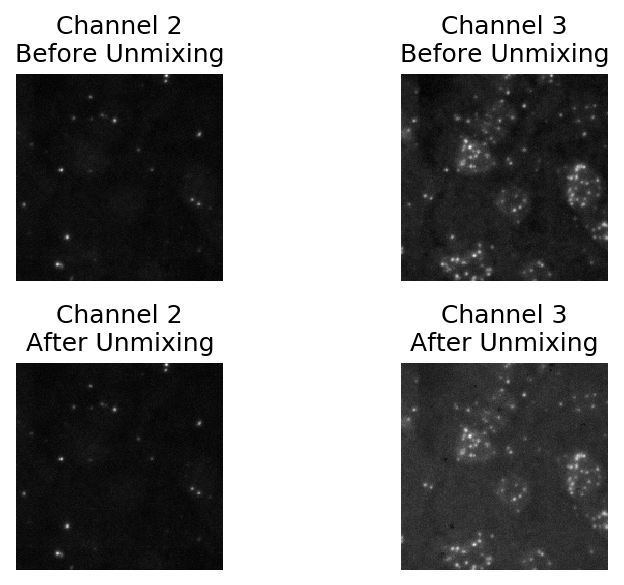

In [18]:
# TODO ambrosejcarr fix this.
ch2_r0 = {Axes.CH: 2, Axes.ROUND: 0, Axes.X: (500, 700), Axes.Y: (500, 700)}
ch3_r0 = {Axes.CH: 3, Axes.ROUND: 0, Axes.X: (500, 700), Axes.Y: (500, 700)}
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
imshow_plane(
    registration_corrected,
    sel=ch2_r0, ax=ax1, title="Channel 2\nBefore Unmixing"
)
imshow_plane(
    registration_corrected,
    sel=ch3_r0, ax=ax2, title="Channel 3\nBefore Unmixing"
)
imshow_plane(
    bleed_corrected,
    sel=ch2_r0, ax=ax3, title="Channel 2\nAfter Unmixing"
)
imshow_plane(
    bleed_corrected,
    sel=ch3_r0, ax=ax4, title="Channel 3\nAfter Unmixing"
)
f.tight_layout()

Remove image background
-----------------------
To remove image background, BaristaSeq uses a White Tophat filter, which
measures the background with a rolling disk morphological element and
subtracts it from the image.

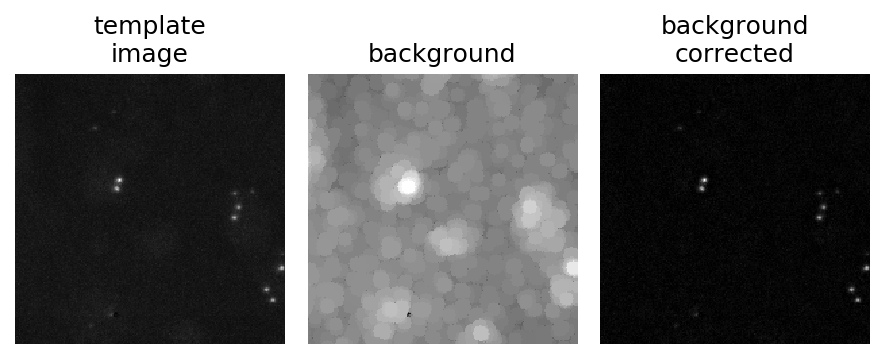

In [19]:
from skimage.morphology import opening, dilation, disk
from functools import partial

# calculate the background
opening = partial(opening, selem=disk(5))

background = bleed_corrected.apply(
    opening,
    group_by={Axes.ROUND, Axes.CH, Axes.ZPLANE}, verbose=False, in_place=False
)

wth = starfish.image.Filter.WhiteTophat(masking_radius=5)
background_corrected = wth.run(bleed_corrected, in_place=False)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3)
selector = {Axes.CH: 0, Axes.ROUND: 0, Axes.X: (500, 700), Axes.Y: (500, 700)}
imshow_plane(bleed_corrected, sel=selector, ax=ax1, title="template\nimage")
imshow_plane(background, sel=selector, ax=ax2, title="background")
imshow_plane(
    background_corrected, sel=selector, ax=ax3, title="background\ncorrected"
)
f.tight_layout()

Scale images to equalize spot intensities across channels
---------------------------------------------------------
The number of peaks are not uniform across rounds and channels,
which prevents histogram matching across channels. Instead, a percentile value
is identified and set as the maximum across channels, and the dynamic range is
extended to equalize the channel intensities. We first demonatrate what
scaling by the max value does.

In [20]:
sbp = starfish.image.Filter.Clip(p_max=100, expand_dynamic_range=True)
scaled = sbp.run(background_corrected, n_processes=1, in_place=False)

/Users/mcai/starfish-CI/starfish/starfish/core/image/Filter/clip.py:72: UserWarning: Parameter `expand_dynamic_range` is deprecated.  Please use the level_method instead.
  f"Parameter `expand_dynamic_range` is deprecated.  Please use the level_method "


The easiest way to visualize this is to calculate the intensity histograms
before and after this scaling and plot their log-transformed values. This
should see that the histograms are better aligned in terms of intensities.
It gets most of what we want, but the histograms are still slightly shifted;
a result of high-value outliers.

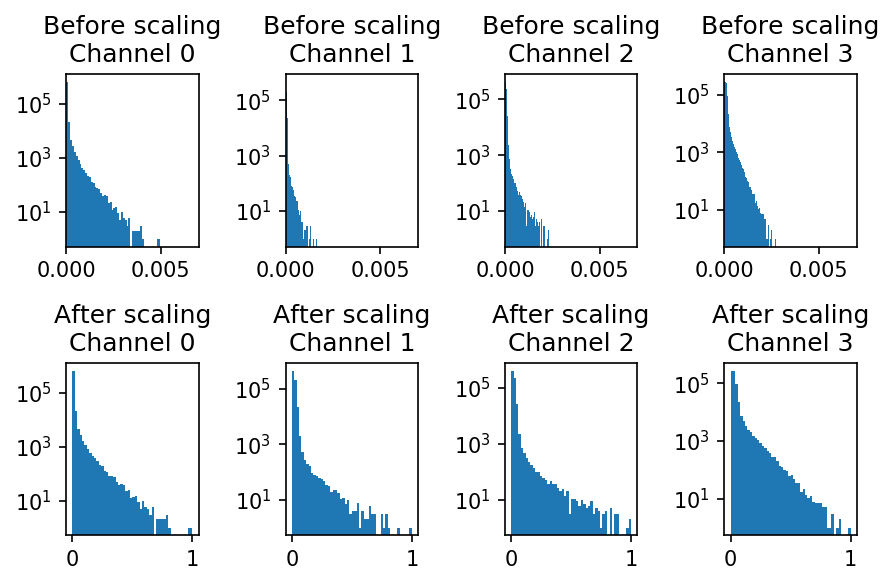

In [21]:
def plot_scaling_result(
    template: starfish.ImageStack, scaled: starfish.ImageStack
):
    f, (before, after) = plt.subplots(ncols=4, nrows=2)
    for channel, ax in enumerate(before):
        title = f'Before scaling\nChannel {channel}'
        intensity_histogram(
            template, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
        ax.set_xlim(0, 0.007)
    for channel, ax in enumerate(after):
        title = f'After scaling\nChannel {channel}'
        intensity_histogram(
            scaled, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
    f.tight_layout()
    return f

f = plot_scaling_result(background_corrected, scaled)

We repeat this scaling by the 99.8th percentile value, which does a better job
of equalizing the intensity distributions.

It should also be visible that exactly 0.2% of values take on the max value
of 1. This is a result of setting any value above the 99.8th percentile to 1,
and is a trade-off made to eliminate large-value outliers.

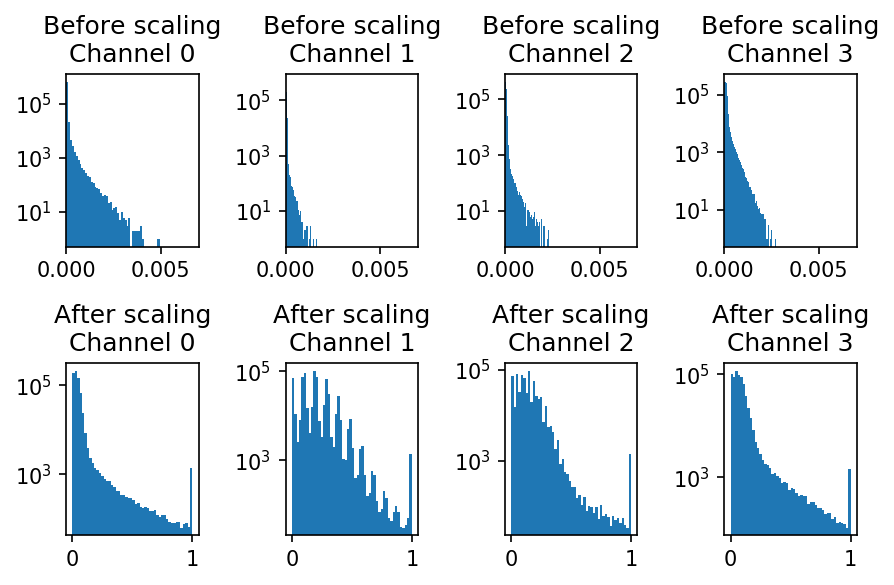

In [22]:
sbp = starfish.image.Filter.Clip(p_max=99.8, expand_dynamic_range=True)
scaled = sbp.run(background_corrected, n_processes=1, in_place=False)

f = plot_scaling_result(background_corrected, scaled)

## Detect Spots
We use a pixel spot decoder to identify the gene target for each spot.

In [23]:
psd = starfish.spots.DetectPixels.PixelSpotDecoder(
    codebook=exp.codebook, metric='euclidean', distance_threshold=0.5,
    magnitude_threshold=0.1, min_area=7, max_area=50
)
pixel_decoded, ccdr = psd.run(scaled)

100%|██████████| 5649/5649 [00:00<00:00, 23360.57it/s]


plot a mask that shows where pixels have decoded to genes.

Text(0.5, 1.0, 'Pixel Decoding Results')

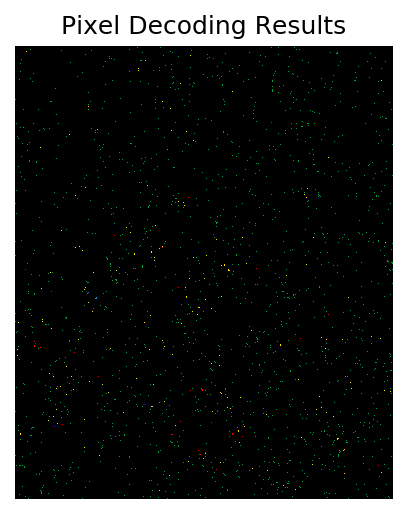

In [24]:
f, ax = plt.subplots()
ax.imshow(np.squeeze(ccdr.decoded_image), cmap=plt.cm.nipy_spectral)
ax.axis("off")
ax.set_title("Pixel Decoding Results")

Get the total counts for each gene from each spot detector.
Do the below values make sense for this tissue and this probeset?

In [25]:
pixel_decoded_gene_counts = pd.Series(
    *np.unique(pixel_decoded['target'], return_counts=True)[::-1]
)

print(pixel_decoded_gene_counts.sort_values(ascending=False)[:20])

Gad2        5017
Serpine2     499
Slc17a7      104
Slc30a3       10
Gad1           8
Fam19a9        7
Ptprk          4
dtype: int64
